# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp pbh

In [ ]:
#| hide
from nbdev.showdoc import *

In [178]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad, dblquad
from scipy.interpolate import interp1d, interp2d
from tqdm import tqdm
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from numba import njit
import pickle

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
#| export
with open('../interpolations/ut_interp_m31.pkl', 'rb') as f:
    ut_interp = pickle.load(f)

In [196]:
#| export
class Pbh:
    """A class to represent a PBH population"""

    def __init__(self,
                m_pbh: float, # PBH mass in solar masses
                f_dm: float # PBH fraction of the DM density
                ):
        """
        Initialize the PBH population
        """
        if m_pbh < m_low_interp or m_pbh > m_high_interp:
            raise ValueError("m_pbh must be between 1e-16 and 1e-4 or a different interpolation function must be used for u_t")
        self.m_pbh = m_pbh
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
        self.ut_interp = ut_interp
    
    def __str__(self) -> str:
        return f"PBH population with m_pbh={self.m_pbh} and f_dm={self.f_dm}"
    __repr__ = __str__

    def density(self, d: float) -> float:
        rmw = dist_mw(d)
        rm31 = dist_m31(d)
        return self.f_dm *(density_mw(rmw) + density_m31(rm31))
    
    def differential_rate_integrand_mw(self, umin, d, t, finite=False):
        r = dist_mw(d)
        ut = self.umin_upper_bound(d) if (self.ut_interp and finite) else 1
        if ut <= umin:
            return 0
        v_rad = velocity_radial(d, self.m_pbh, umin, t * htosec, ut)
        v_disp = velocity_dispersion_mw(r)
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                density_mw(r) / (self.m_pbh * v_disp**2) *
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)))
    
    def differential_rate_integrand_m31(self, umin, d, t, finite=False):
        r = dist_m31(d)
        ut = self.umin_upper_bound(d) if (self.ut_interp and finite) else 1
        if ut <= umin:
            return 0
        v_rad = velocity_radial(d, self.m_pbh, umin, t * htosec, ut)
        v_disp = velocity_dispersion_m31(r)
        
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                density_m31(r) / (self.m_pbh * v_disp**2) *
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)))
    
    def differential_rate_integrand(self, umin, d, t, finite=False):
        ut = self.umin_upper_bound(d) if (self.ut_interp and finite) else 1
        if ut <= umin:
            return 0
        return self.differential_rate_integrand_mw(umin, d, t, finite) + self.differential_rate_integrand_m31(umin, d, t, finite)
    
    def differential_rate_mw(self, t, finite=False):

        if finite:
            result, error = dblquad(self.differential_rate_integrand_mw, 0, ds, self.umin_lower_bound, self.umin_upper_bound, args=(t,))
            return result    

        else:
            umin_bounds = [0, ut]
            d_bounds = [0, ds]
            result, error = nquad(self.differential_rate_integrand_mw, [umin_bounds, d_bounds], args=[t])
            return result
    
    def differential_rate_m31(self, t, finite=False):
        if finite:
            result, error = dblquad(self.differential_rate_integrand_m31, 0, ds, self.umin_lower_bound, self.umin_upper_bound, args=(t,))
            return result    

        else:
            umin_bounds = [0, ut]
            d_bounds = [0, ds]
            result, error = nquad(self.differential_rate_integrand_m31, [umin_bounds, d_bounds], args=[t])
            return result

    def umin_lower_bound(self, d):
        return 0
    
    def umin_upper_bound(self, d):
        if self.ut_interp is None:
            self.make_ut_interp()
        return self.ut_interp(d, self.m_pbh)[0]
    
    def differential_rate(self, t, finite=False):
        #The integral is a bit sensitive to the bounds, so we have to be careful
        #For m31 there's a singularity at d=ds

        if finite:
   
            result, error = dblquad(self.differential_rate_integrand, 0, ds, self.umin_lower_bound, self.umin_upper_bound, args=(t,))
            return result    

        else:
            umin_bounds = [0, ut]
            d_bounds = [0, ds]
            result, error = nquad(self.differential_rate_integrand, [umin_bounds, d_bounds], args=[t])
            return result
            
    def compute_differential_rates(self, ts, finite=False):
        # with Pool() as p:
        #     f = functools.partial(self.differential_rate, finite=finite)
        #     results = list(p.imap(f, ts))
        # return results
        return [self.differential_rate(t, finite=finite) for t in ts]

In [197]:
pbh = Pbh(1e-8, 1)
ts = np.logspace(-2,1,50)

NameError: name 'm_low_interp' is not defined

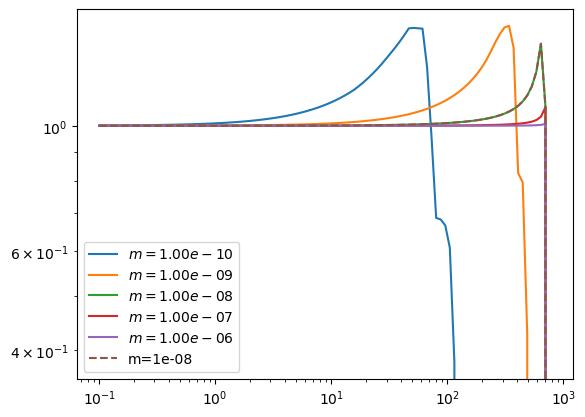

In [198]:
d_arr = np.logspace(-1, np.log10(ds), 100)
m_pbh_arr = np.logspace(-10, -6, 5)

for m in m_pbh_arr:
    plt.loglog(d_arr, pbh.ut_interp(d_arr, m), label=f"$m= {m:.2e}$")

plt.loglog(d_arr, [pbh.umin_upper_bound(d) for d in d_arr], label="m={}".format(pbh.m_pbh), ls="--")

plt.legend()
plt.show()

In [163]:
result_mw = [pbh.differential_rate_mw(t, finite=False) for t in ts]
result_m31 = [pbh.differential_rate_m31(t, finite=False) for t in ts]

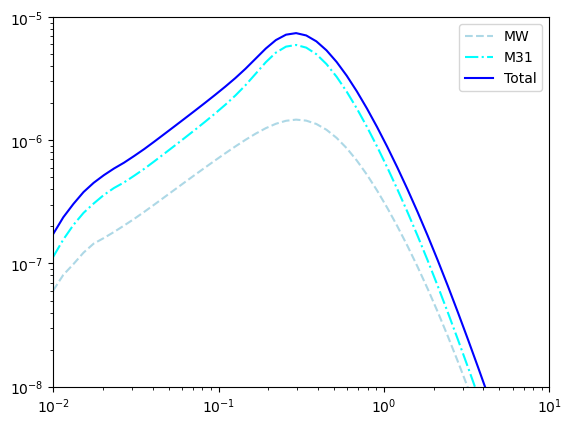

In [97]:
plt.loglog(ts, result_mw, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31, label="M31", color="cyan", linestyle="-.")
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total", color="blue")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

In [167]:
result_mw_finite = [pbh.differential_rate_mw(t, finite=True) for t in ts]
result_m31_finite = [pbh.differential_rate_m31(t, finite=True) for t in ts]

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


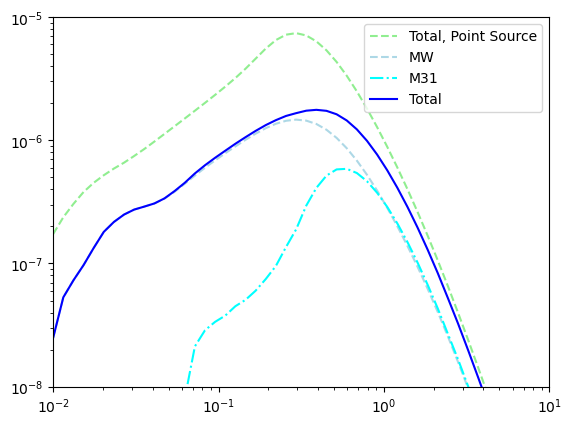

In [168]:
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total, Point Source", color="lightgreen", linestyle="--")
plt.loglog(ts, result_mw_finite, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31_finite, label="M31", color="cyan", linestyle="-.")
plt.loglog(ts, np.array(result_mw_finite) + np.array(result_m31_finite), label="Total", color="blue")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

In [16]:
ts = np.logspace(-2, 3, 100)
pbhs = [Pbh(10**(i), 1) for i in np.linspace(-5, -3, 3)]
result = np.zeros((len(pbhs), len(ts)))
for i, pbh in enumerate(pbhs):
    for j, t in enumerate(ts):
        result[i, j] = pbh.differential_rate(t)
    

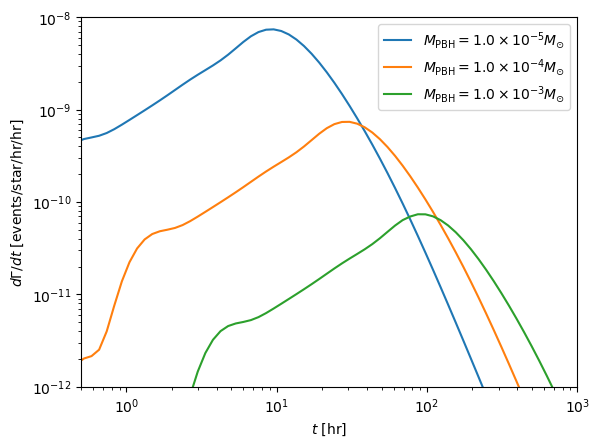

In [18]:
for i, pbh in enumerate(pbhs):
    # plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = " + str(pbh.m_pbh) + "M_{\odot}$")
    plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = $" + scientific_format(pbh.m_pbh,0) + "$M_{\odot}$")


plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xlim(5e-1, 1e3)
plt.ylim(1e-12, 1e-8)

plt.legend()
plt.show()


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()